In [ ]:
pip install linearsolve

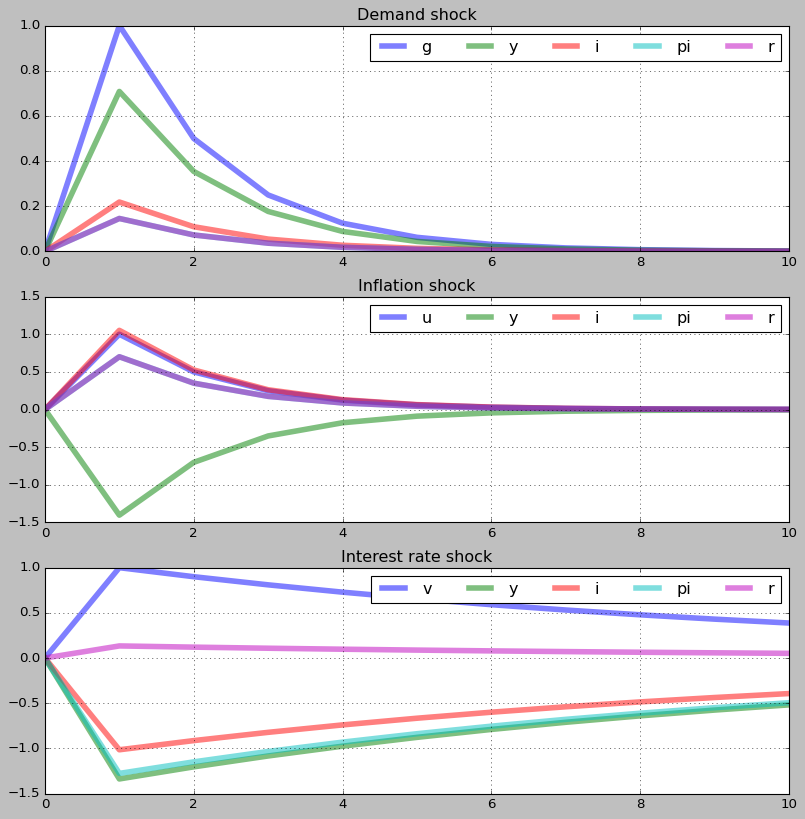

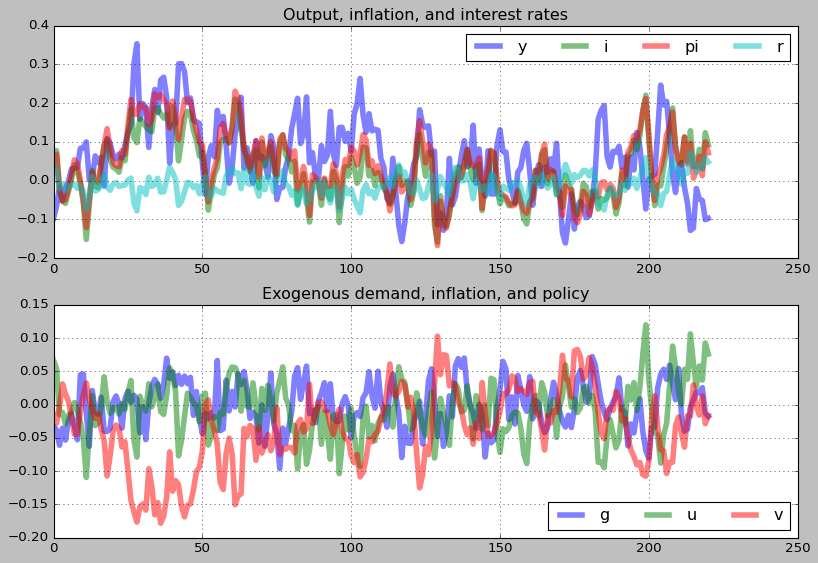

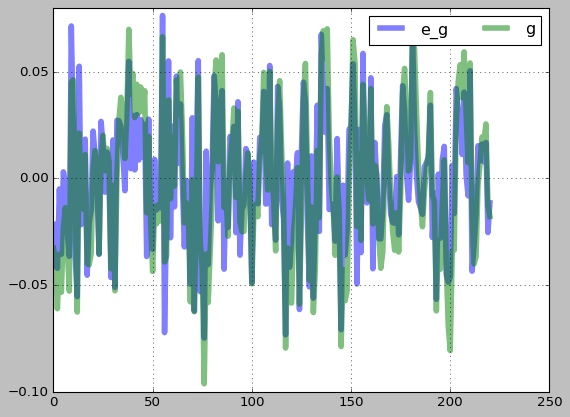

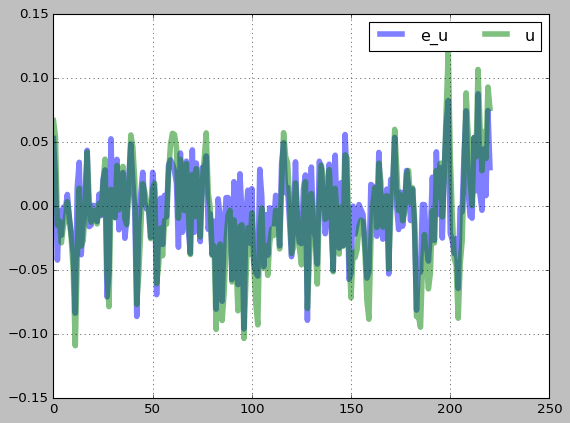

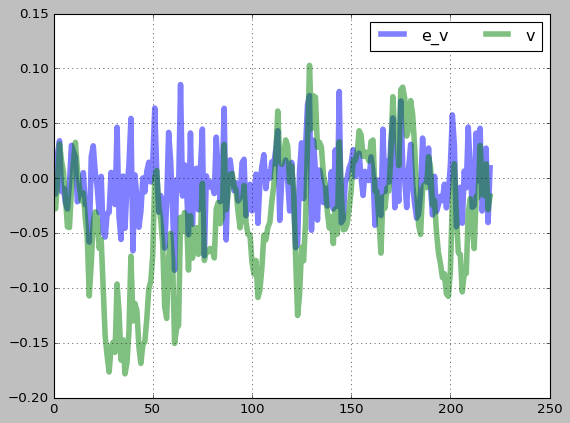

In [ ]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# Параметры модели
beta = 0.99
sigma= 1
eta  = 1
omega= 0.8
kappa= (sigma+eta)*(1-omega)*(1-beta*omega)/omega

rhor = 0.9
phipi= 1.5
phiy = 0

rhog = 0.5
rhou = 0.5
rhov = 0.9

Sigma = 0.001*np.eye(3)


parameters = pd.Series({
    'beta':beta,
    'sigma':sigma,
    'eta':eta,
    'omega':omega,
    'kappa':kappa,
    'rhor':rhor,
    'phipi':phipi,
    'phiy':phiy,
    'rhog':rhog,
    'rhou':rhou,
    'rhov':rhov
})


# Определение функции, которая вычисляет условия равновесия
def equations(variables_forward,variables_current,parameters):

    # Parameters
    p = parameters

    # Variables
    fwd = variables_forward
    cur = variables_current

    # Exogenous demand
    g_proc =  p.rhog*cur.g - fwd.g

    # Exogenous inflation
    u_proc =  p.rhou*cur.u - fwd.u

    # Exogenous monetary policy
    v_proc =  p.rhov*cur.v - fwd.v

    # Euler equation
    euler_eqn = fwd.y -1/p.sigma*(cur.i-fwd.pi) + fwd.g - cur.y

    # NK Phillips curve evolution
    phillips_curve = p.beta*fwd.pi + p.kappa*cur.y + fwd.u - cur.pi

    # interest rate rule
    interest_rule = p.phiy*cur.y+p.phipi*cur.pi + fwd.v - cur.i

    # Fisher equation
    fisher_eqn = cur.i - fwd.pi - cur.r


    # Stack equilibrium conditions into a numpy array
    return np.array([
            g_proc,
            u_proc,
            v_proc,
            euler_eqn,
            phillips_curve,
            interest_rule,
            fisher_eqn
        ])

# Initialize the nk model
nk = ls.model(equations=equations,
              n_states=3,
              n_exo_states = 3,
              var_names=['g','u','v','i','r','y','pi'],
              parameters=parameters)

# Set the steady state of the nk model
nk.set_ss([0,0,0,0,0,0,0])

# Find the log-linear approximation around the non-stochastic steady state
nk.linear_approximation()

# Solve the nk model
nk.solve_klein(nk.a,nk.b)

# Compute impulse responses
nk.impulse(T=11,t0=1,shocks=None)

# Create the figure and axes
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

# Plot commands
nk.irs['e_g'][['g','y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Demand shock',ax=ax1).legend(loc='upper right',ncol=5)
nk.irs['e_u'][['u','y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Inflation shock',ax=ax2).legend(loc='upper right',ncol=5)
nk.irs['e_v'][['v','y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Interest rate shock',ax=ax3).legend(loc='upper right',ncol=5)

# Compute stochastic simulation
nk.stoch_sim(T=221,drop_first=100,cov_mat=Sigma,seed=0)

# Create the figure and axes
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

# Plot commands
nk.simulated[['y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Output, inflation, and interest rates',ax=ax1).legend(ncol=4)
nk.simulated[['g','u','v']].plot(lw='5',alpha=0.5,grid=True,title='Exogenous demand, inflation, and policy',ax=ax2).legend(ncol=4,loc='lower right')

# Plot simulated exogenous shocks
nk.simulated[['e_g','g']].plot(lw='5',alpha=0.5,grid=True).legend(ncol=2)
nk.simulated[['e_u','u']].plot(lw='5',alpha=0.5,grid=True).legend(ncol=2)
nk.simulated[['e_v','v']].plot(lw='5',alpha=0.5,grid=True).legend(ncol=2)

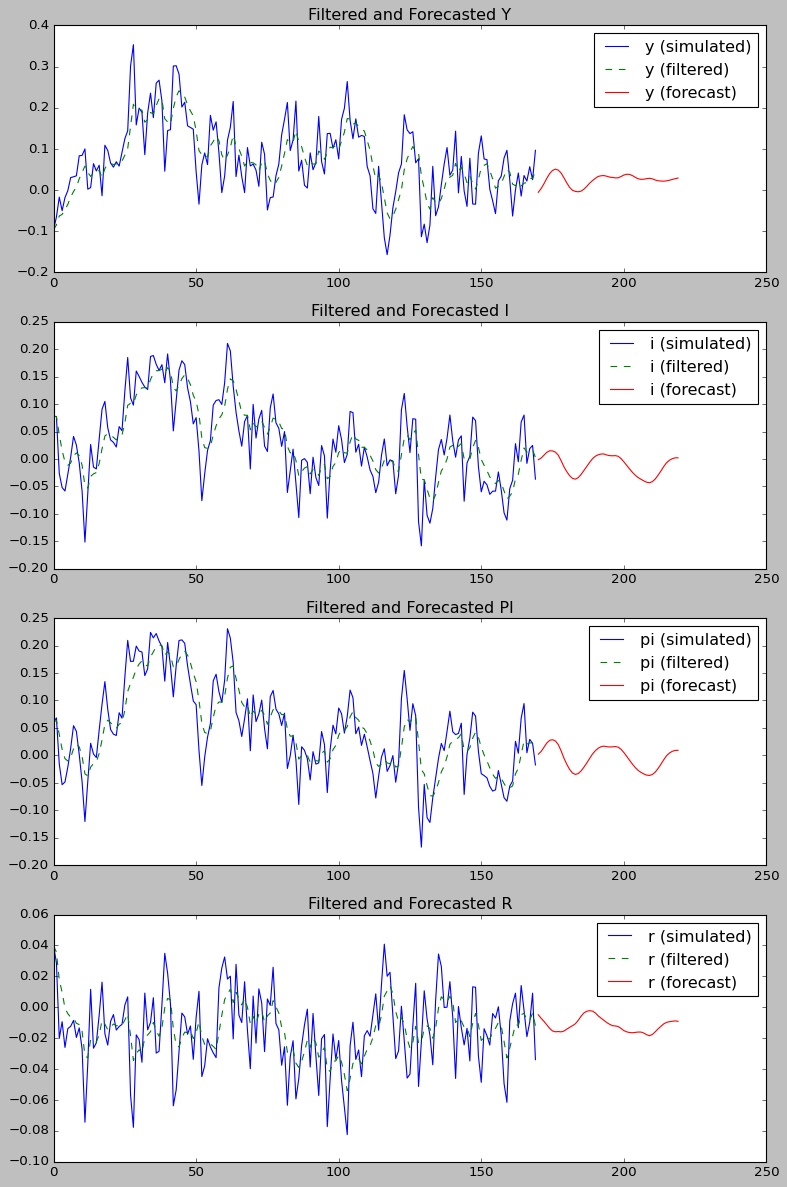

In [ ]:
# Загрузка симулированных данных из вашей модели
simulated_data = pd.DataFrame(nk.simulated.iloc[0:170][['y','i','pi','r']])

# Определение начальных значений для фильтра Калмана
initial_state_mean = simulated_data.iloc[0].values
initial_state_covariance = np.eye(4) * 0.001

# Матрица перехода состояния
transition_matrix = np.eye(4)

# Матрица наблюдения
observation_matrix = np.eye(4)

# Определение шума процесса и шума наблюдения
transition_covariance = np.eye(4) * 0.0001
observation_covariance = np.eye(4) * 0.001

# Создание фильтра Калмана
kf = KalmanFilter(
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    transition_covariance=transition_covariance,
    observation_covariance=observation_covariance
)

# Применение фильтра Калмана к данным
state_means, state_covariances = kf.filter(simulated_data.values)

# Прогнозирование будущих значений
n_forecast_steps = 50 # Количество шагов для прогнозирования
forecast_means, forecast_covariances = kf.smooth(state_means)


# Преобразование результатов прогноза в DataFrame
forecast_data = pd.DataFrame(forecast_means, columns=['y_forecast','i_forecast','pi_forecast','r_forecast'])

# Создание фигуры и осей для графиков
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

# Названия переменных
variables = ['y', 'i', 'pi', 'r']

# Цикл для создания графика для каждой переменной
for i, var in enumerate(variables):
    # График отфильтрованных данных
    axes[i].plot(simulated_data.index, simulated_data[var], label=f'{var} (simulated)')
    axes[i].plot(simulated_data.index, state_means[:, i], label=f'{var} (filtered)', linestyle='--')

    # График прогнозируемых данных
    forecast_index = range(len(simulated_data), len(simulated_data) + n_forecast_steps)
    axes[i].plot(forecast_index, forecast_means[-n_forecast_steps:, i], label=f'{var} (forecast)', marker='')

    # Добавление легенды и заголовка
    axes[i].legend()
    axes[i].set_title(f'Filtered and Forecasted {var.upper()}')

# Показать графики
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# Функция для расчета коэффициента корреляции Пирсона и статистических метрик
def evaluate_filter(simulated, filtered):
    # Расчет коэффициента корреляции Пирсона
    pearson_coefficients = {}
    for var in ['y', 'i', 'pi', 'r']:
        coeff, _ = pearsonr(simulated[var], filtered[f'{var}_filtered'])
        pearson_coefficients[var] = coeff

    # Расчет статистических метрик
    stats = filtered.describe().loc[['mean', '50%', 'std']]
    stats.rename(index={'50%': 'median'}, inplace=True)

    return pearson_coefficients, stats

# Вызов функции и вывод результатов
pearson_coefficients, stats = evaluate_filter(simulated_data, filtered_data)


# Функция для расчета статистических метрик для симулированных данных
def calculate_stats_before_filter(simulated):
    stats_before_filter = simulated.describe().loc[['mean', '50%', 'std']]
    stats_before_filter.rename(index={'50%': 'median'}, inplace=True)
    return stats_before_filter

# Вызов функции и вывод результатов
stats_before_filter = calculate_stats_before_filter(simulated_data)

print("Статистические метрики для симулированных данных до фильтрации:")
print(stats_before_filter)

print("\nСтатистические метрики для отфильтрованных данных:")
print(stats)

print("\nКоэффициенты корреляции Пирсона:")
for var, coeff in pearson_coefficients.items():
    print(f"{var}: {coeff:.2f}")


Статистические метрики для симулированных данных до фильтрации:
               y         i        pi         r
mean    0.074106  0.030703  0.046697 -0.014974
median  0.065624  0.024519  0.039623 -0.014677
std     0.093032  0.076804  0.083636  0.024550

Статистические метрики для отфильтрованных данных:
        y_filtered  i_filtered  pi_filtered  r_filtered
mean      0.076058    0.044330     0.061212   -0.013227
median    0.088667    0.044428     0.063095   -0.014801
std       0.041048    0.025307     0.029739    0.007048

Коэффициенты корреляции Пирсона:
y: 0.28
i: 0.33
pi: 0.34
r: 0.21


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error

real_data = nk.simulated.iloc[170:220][['y', 'i', 'pi', 'r']]

# Вычисление среднеквадратичной ошибки для прогнозируемых значений
mse_y_forecast = mean_squared_error(real_data['y'], forecast_data['y_forecast'][:50])
mse_i_forecast = mean_squared_error(real_data['i'], forecast_data['i_forecast'][:50])
mse_pi_forecast = mean_squared_error(real_data['pi'], forecast_data['pi_forecast'][:50])
mse_r_forecast = mean_squared_error(real_data['r'], forecast_data['r_forecast'][:50])

# Вычисление средней абсолютной ошибки для прогнозируемых значений
mae_y_forecast = mean_absolute_error(real_data['y'], forecast_data['y_forecast'][:50])
mae_i_forecast = mean_absolute_error(real_data['i'], forecast_data['i_forecast'][:50])
mae_pi_forecast = mean_absolute_error(real_data['pi'], forecast_data['pi_forecast'][:50])
mae_r_forecast = mean_absolute_error(real_data['r'], forecast_data['r_forecast'][:50])

# Вычисление RMSE
rmse_y = np.sqrt(mean_squared_error(real_data['y'], forecast_data['y_forecast'][:50]))
rmse_i = np.sqrt(mean_squared_error(real_data['i'], forecast_data['i_forecast'][:50]))
rmse_pi = np.sqrt(mean_squared_error(real_data['pi'], forecast_data['pi_forecast'][:50]))
rmse_r = np.sqrt(mean_squared_error(real_data['r'], forecast_data['r_forecast'][:50]))

# Вывод метрик
print(f'Среднеквадратичная ошибка  для Y: {mse_y_forecast}')
print(f'Среднеквадратичная ошибка  для I: {mse_i_forecast}')
print(f'Среднеквадратичная ошибка  для PI: {mse_pi_forecast}')
print(f'Среднеквадратичная ошибка  для R: {mse_r_forecast}')

print(f'Средняя абсолютная ошибка  для Y: {mae_y_forecast}')
print(f'Средняя абсолютная ошибка  для I: {mae_i_forecast}')
print(f'Средняя абсолютная ошибка  для PI: {mae_pi_forecast}')
print(f'Средняя абсолютная ошибка  для R: {mae_r_forecast}')

print(f'Корень из среднеквадратичной ошибки (RMSE) для Y: {rmse_y}')
print(f'Корень из среднеквадратичной ошибки (RMSE) для I: {rmse_i}')
print(f'Корень из среднеквадратичной ошибки (RMSE) для PI: {rmse_pi}')
print(f'Корень из среднеквадратичной ошибки (RMSE) для R: {rmse_r}')

Среднеквадратичная ошибка  для Y: 0.0197985773717412
Среднеквадратичная ошибка  для I: 0.005597318863909647
Среднеквадратичная ошибка  для PI: 0.007773608825237544
Среднеквадратичная ошибка  для R: 0.0013508247560616341
Средняя абсолютная ошибка  для Y: 0.11023135932597143
Средняя абсолютная ошибка  для I: 0.06087856940571561
Средняя абсолютная ошибка  для PI: 0.0726719034385379
Средняя абсолютная ошибка  для R: 0.030052945992804538
Корень из среднеквадратичной ошибки (RMSE) для Y: 0.14070741761449962
Корень из среднеквадратичной ошибки (RMSE) для I: 0.07481523149673232
Корень из среднеквадратичной ошибки (RMSE) для PI: 0.0881680714614851
Корень из среднеквадратичной ошибки (RMSE) для R: 0.0367535679364825


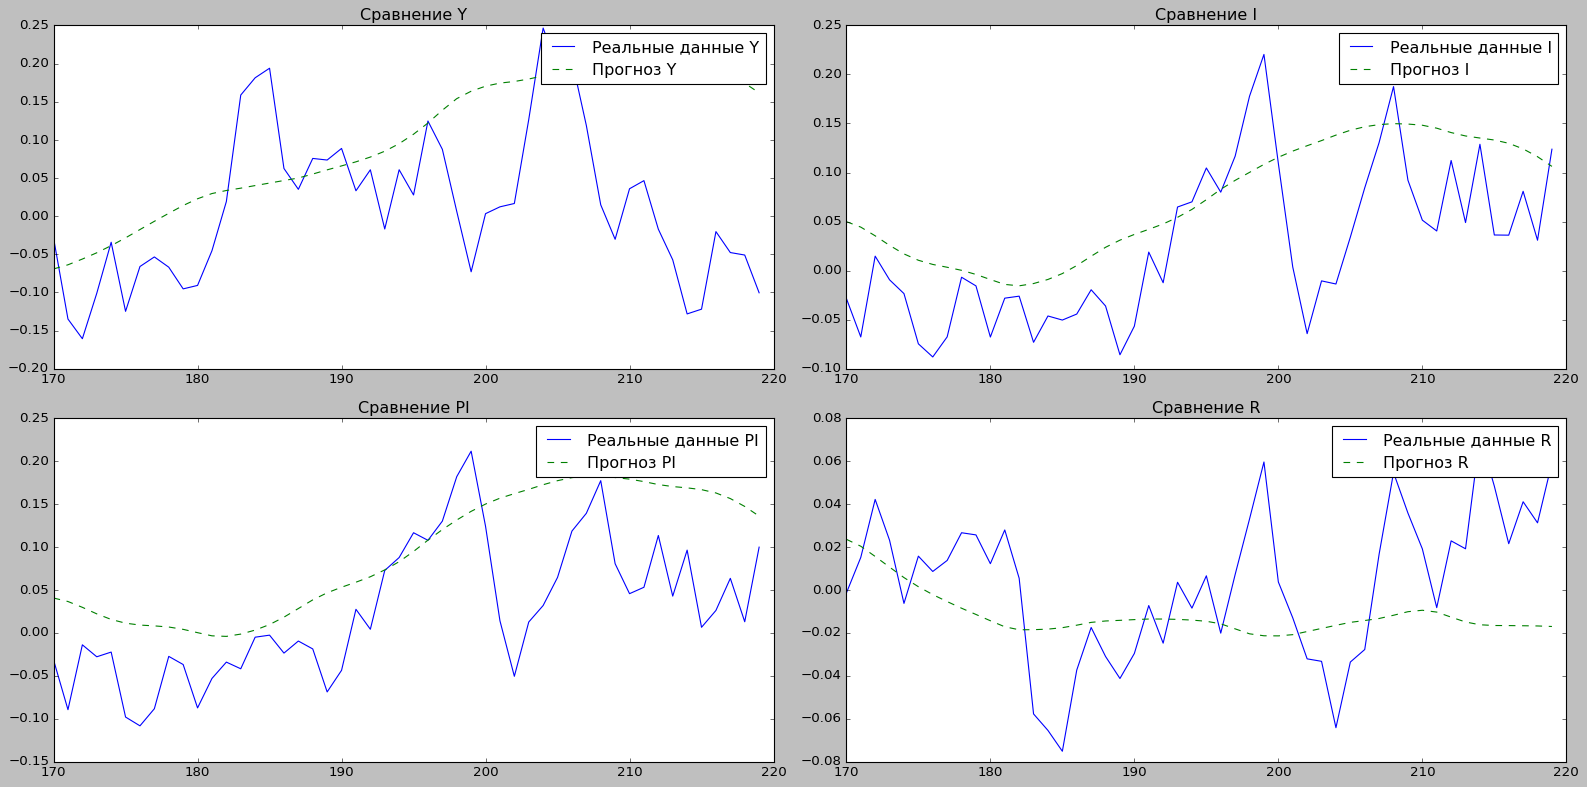

In [ ]:
# Создание фигуры и осей
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# График для Y
axs[0, 0].plot(real_data.index, real_data['y'], label='Реальные данные Y')
axs[0, 0].plot(real_data.index, forecast_data['y_forecast'][:50], label='Прогноз Y', linestyle='--')
axs[0, 0].set_title('Сравнение Y')
axs[0, 0].legend()

# График для I
axs[0, 1].plot(real_data.index, real_data['i'], label='Реальные данные I')
axs[0, 1].plot(real_data.index, forecast_data['i_forecast'][:50], label='Прогноз I', linestyle='--')
axs[0, 1].set_title('Сравнение I')
axs[0, 1].legend()

# График для PI
axs[1, 0].plot(real_data.index, real_data['pi'], label='Реальные данные PI')
axs[1, 0].plot(real_data.index, forecast_data['pi_forecast'][:50], label='Прогноз PI', linestyle='--')
axs[1, 0].set_title('Сравнение PI')
axs[1, 0].legend()

# График для R
axs[1, 1].plot(real_data.index, real_data['r'], label='Реальные данные R')
axs[1, 1].plot(real_data.index, forecast_data['r_forecast'][:50], label='Прогноз R', linestyle='--')
axs[1, 1].set_title('Сравнение R')
axs[1, 1].legend()

# Отображение графика
plt.tight_layout()
plt.show()
